# [실습] 포트폴리오 : 채권 비율
* Data Load
* EDA : 총누적배당금, 일일수익률, 만기수익률, 변동성(위험) 대비 수익률, 수익률간 상관관계
* 샤프 지수에 따른 포트폴리오 비율 산정
* 최적의 수익률, 변동성

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data Load

In [2]:
#------------------------------------------------
# 주가 & 배당금
#------------------------------------------------
class YFinance():
    def __init__(self, tickers, period):
        self.period = period       
        self.df_price     = pd.DataFrame()
        self.df_dividends = pd.DataFrame()
        for ticker in tickers:
            print(f'ticker : {ticker}')
            full_data = yf.Ticker(ticker).history(start=self.period[0], end=self.period[1])
            full_data.index = pd.to_datetime(full_data.index.strftime('%Y-%m-%d'), format='%Y-%m-%d')
            self.df_price[ticker]     = full_data['Close']
            self.df_dividends[ticker] = full_data['Dividends']
            time.sleep(0.5)            
    def get_price(self):  
        self.df_price.columns = ['us_stock','kr_stock','us_bond','kr_bond']
        return self.df_price
        
    def get_dividends(self):
        self.df_dividends.columns = ['us_stock','kr_stock','us_bond','kr_bond']
        return self.df_dividends

In [3]:
tickers      = ['SPY', '^KS11','IEF', '148070.KS'] # 채권 :각 국가의 7~10년물 국채 
# start_date   = '2017-01-01'
# end_date     = '2021-12-31'
start_date = '2012-02-28'
end_date = '2022-02-28'
y_finance    = YFinance(tickers=tickers, period=(start_date, end_date))

yf_price     = y_finance.get_price()       # 주가
yf_dividends = y_finance.get_dividends()   # 배당금
print(yf_price.shape, yf_dividends.shape)

ticker : SPY
ticker : ^KS11
ticker : IEF
ticker : 148070.KS
(2517, 4) (2517, 4)


In [4]:
# yf_dividends[  (yf_dividends.notna())   &   (yf_dividends > 0)  ]

In [5]:
yf_dividends.head(100)

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2012-02-28,0.0,0.0,0.00,0.0
2012-02-29,0.0,0.0,0.00,0.0
2012-03-01,0.0,NaN,0.17,NaN
2012-03-02,0.0,0.0,0.00,0.0
2012-03-05,0.0,0.0,0.00,0.0
...,...,...,...,...
2012-07-13,0.0,0.0,0.00,0.0
2012-07-16,0.0,0.0,0.00,0.0
2012-07-17,0.0,0.0,0.00,0.0


In [6]:
# """
# S&P 500 (^GSPC)
# KOSPI Composite Index (^KS11)
# iShares Core 10+ Year USD Bond ETF (ILTB)
# KOSEF 10yr KTB (148070.KS)
# """
# tickers      = ['^GSPC', '^KS11','ILTB', '148070.KS'] # 주식:지수,  채권:10년물 국채 
# start_date = '2012-02-28'
# end_date = '2022-02-28'

# from pandas_datareader import data as pdr
# import yfinance as yf
# yf.pdr_override()
# df = pdr.get_data_yahoo(tickers, start_date, end_date)['Close']
# df.rename(columns = {'^GSPC': 'us_stock' ,'^KS11': 'kr_stock','ILTB' : 'us_bond','148070.KS': 'kr_bond'}
#           , inplace = True)
# df.shape

# df = df.fillna(method='ffill')
# df = df.fillna(method='bfill')
# df.info()
# df.head()

# 기준금리(Base Rate)
* https://ecos.bok.or.kr/api/#/https://ecos.bok.or.kr/api/#/

In [7]:
import requests
apikey = '62TDLQ10E6ANSZGZB792'
url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + apikey \
        + '/json/kr/1/100/902Y006/M/200101/202212'
response = requests.get(url)
result = response.json()
list_total_count=(int)(result['StatisticSearch']['list_total_count'])
list_count=(int)(list_total_count/100) + 1


rows=[]
for i in range(0,list_count):
    start = str(i * 100 + 1)
    end = str((i + 1) * 100)
    
    url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + apikey + '/json/kr/' \
            + start + '/' + end + '/902Y006/M/200101/202212'
    response = requests.get(url)
    result = response.json()
    rows = rows + result['StatisticSearch']['row']
    
br=pd.DataFrame(rows)
br.head()


,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,ITEM_CODE2,ITEM_NAME2,ITEM_CODE3,ITEM_NAME3,ITEM_CODE4,ITEM_NAME4,UNIT_NAME,TIME,DATA_VALUE
0,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,AU,호주,None,None,None,None,None,None,%,200101,6.25
1,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,BR,브라질,None,None,None,None,None,None,%,200101,15.25
2,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,CA,캐나다,None,None,None,None,None,None,%,200101,5.5
3,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,CH,스위스,None,None,None,None,None,None,%,200101,3.5
4,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,CL,칠레,None,None,None,None,None,None,%,200101,4.75


In [46]:
br.groupby('ITEM_CODE1').first()['ITEM_NAME1'].values

array(['호주', '브라질', '캐나다', '스위스', '칠레', '중국', '체코', '덴마크', '영국', '헝가리',
       '인도네시아', '이스라엘', '인도', '아이슬란드', '일본', '한국', '멕시코', '노르웨이', '뉴질랜드',
       '폴란드', '러시아', '스웨덴', '튀르키예', '미국', '유로 지역', '남아프리카공화국'],
      dtype=object)

In [8]:
u = br[(br['ITEM_CODE1']=='US')][['TIME','DATA_VALUE']]
k = br[(br['ITEM_CODE1']=='KR')][['TIME','DATA_VALUE']]
uk = pd.merge(u,k, on='TIME')
uk = uk.set_index('TIME')
uk['DATA_VALUE_x'] = uk['DATA_VALUE_x'].astype(float)
uk['DATA_VALUE_y'] = uk['DATA_VALUE_y'].astype(float)
uk.columns=["us","kr"]
# uk.info()
# uk.head()

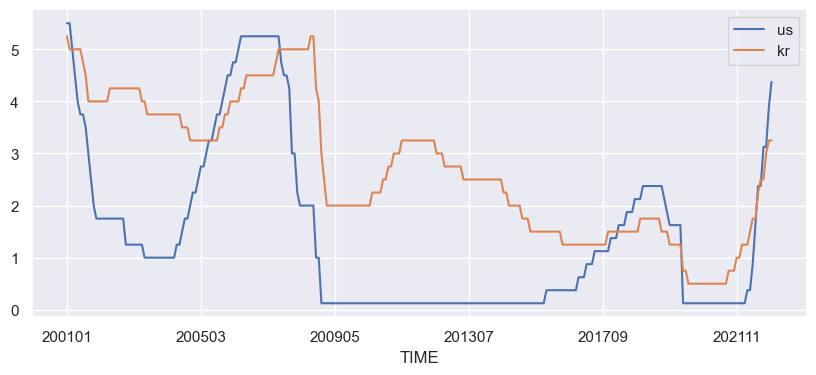

In [9]:
# plt.figure()
uk.plot(figsize=(10,4))
plt.show()

* by 규환

In [10]:
tickers      = ['^GSPC', '^KS11','IEF', '148070.KS'] # 주식:지수,  채권:10년물 국채 
start_date = '2012-02-28'
end_date = '2022-02-28'

sample=pd.DataFrame()
for i, ticker in enumerate(tickers):
    ticker = yf.Ticker(ticker)
    s = ticker.history(interval='1d', start=start_date, end=end_date, auto_adjust=False)[['Close', 'Dividends']]
    s.index = pd.to_datetime(s.index.strftime('%Y-%m-%d'), format='%Y-%m-%d')
    sample = pd.concat([sample, s], axis=1)
    
sample.columns = ['us_stock', '배당1', 'kr_stock', '배당2', 'us_bond', 'us_bond_dividends', 'kr_bond', 'kr_bond_dividends']
sample

,us_stock,배당1,kr_stock,배당2,us_bond,us_bond_dividends,kr_bond,kr_bond_dividends
Date,,,,,,,,
2012-02-28,1372.180054,0.0,2003.689941,0.0,105.540001,0.00,101140.0,0.0
2012-02-29,1365.680054,0.0,2030.250000,0.0,105.120003,0.00,101085.0,0.0
2012-03-01,1374.089966,0.0,NaN,NaN,104.610001,0.17,NaN,NaN
2012-03-02,1369.630005,0.0,2034.630005,0.0,105.029999,0.00,100890.0,0.0
2012-03-05,1364.329956,0.0,2016.060059,0.0,104.820000,0.00,100680.0,0.0
...,...,...,...,...,...,...,...,...
2022-02-21,NaN,NaN,2743.800049,0.0,NaN,NaN,114900.0,0.0
2022-02-22,4304.759766,0.0,2706.790039,0.0,111.209999,0.00,115505.0,0.0
2022-02-23,4225.500000,0.0,2719.530029,0.0,110.629997,0.00,115380.0,0.0


In [13]:
yf_price.head(2)

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2012-02-28,111.345200,2003.689941,86.544800,90899.156250
2012-02-29,110.908089,2030.250000,86.200386,90849.726562


In [14]:
yf_dividends.head(2)

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2012-02-28,0.0,0.0,0.0,0.0
2012-02-29,0.0,0.0,0.0,0.0


In [16]:
yf_price     = yf_price.dropna()
yf_dividends = yf_dividends.dropna()
print(yf_price.shape, yf_dividends.shape) #(1258, 4) (1258, 4)

(2375, 4) (2375, 4)


In [17]:
yf_price.head()

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2012-02-28,111.345200,2003.689941,86.544800,90899.156250
2012-02-29,110.908089,2030.250000,86.200386,90849.726562
2012-03-02,111.142830,2034.630005,86.266151,90674.468750
2012-03-05,110.689552,2016.060059,86.093613,90485.734375
2012-03-06,109.070702,2000.359985,86.454979,90449.781250


In [18]:
yf_price.index.min(), yf_price.index.max()

(Timestamp('2012-02-28 00:00:00'), Timestamp('2022-02-25 00:00:00'))

In [22]:
price_rate = yf_price/yf_price.iloc[0]       #기준일(2017-01-03) 대비 증감
# print( yf_dividends.sum())
# price_rate.head(4)

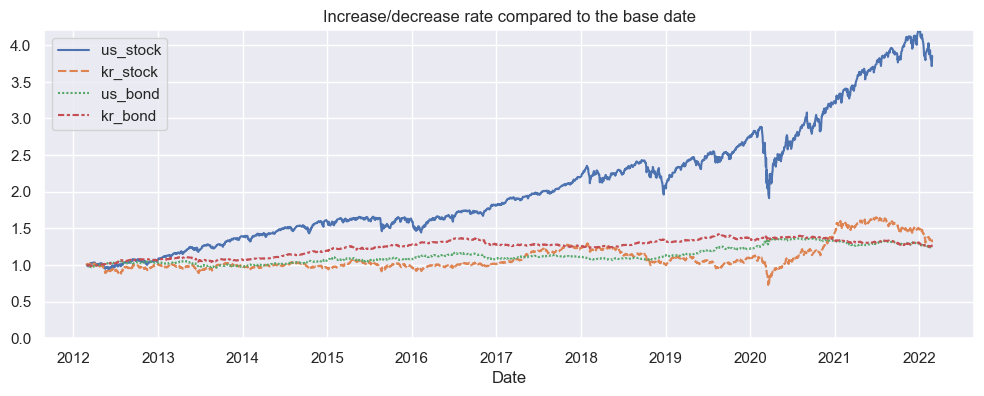

In [23]:
plt.figure(figsize=(12,4))
sns.lineplot(data=price_rate)
plt.ylim((0, price_rate.max().max()))
plt.title('Increase/decrease rate compared to the base date')
plt.show()

# 일일수익률, 만기수익률

In [25]:
pcc = yf_price.pct_change(1)

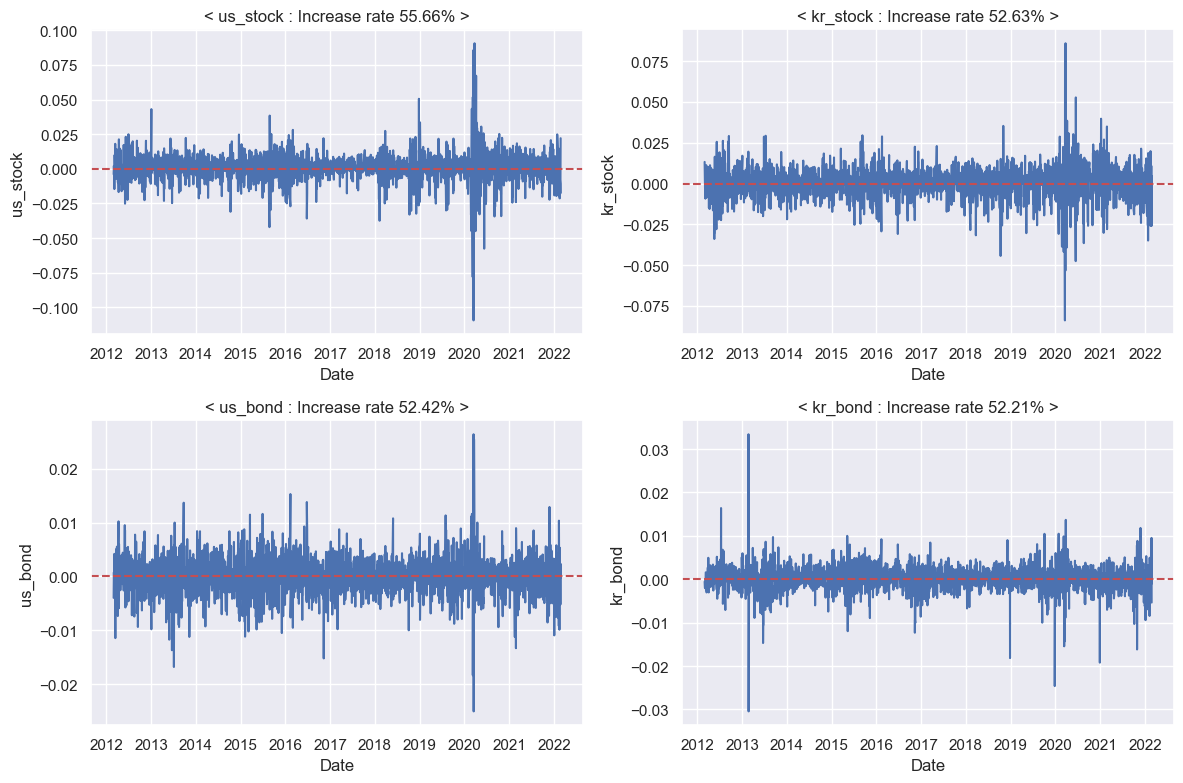

In [27]:
plt.figure(figsize=(12,8))
for i in range(4):
    data = pcc.iloc[:,i]
    plt.subplot(int(f'22{i+1}'))
    sns.lineplot(data=data)
    inc_rate = (data > 0).sum() / len(data) * 100
    plt.title(f'< {data.name} : Increase rate {inc_rate:.2f}% >')
    plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [28]:
pcc.cumsum().tail(1)

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2022-02-25,1.48074,0.404812,0.236961,0.241783


In [29]:
return_rate = np.round(pcc.cumsum().tail(1).values*100, 0)[0]
return_rate

array([148.,  40.,  24.,  24.])

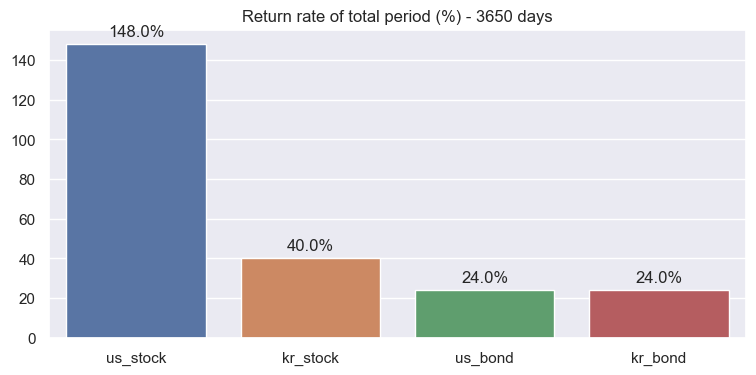

In [30]:
plt.figure(figsize=(9,4))
bars = sns.barplot(x=pcc.columns, y=return_rate)
for p in bars.patches:
    bars.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va='center',
                     xytext = (0,9),
                     textcoords = 'offset points')
    
plt.title(f'Return rate of total period (%) - {(yf_price.index[-1] - yf_price.index[0]).days} days')
plt.show()

## 수익률 간 상관관계

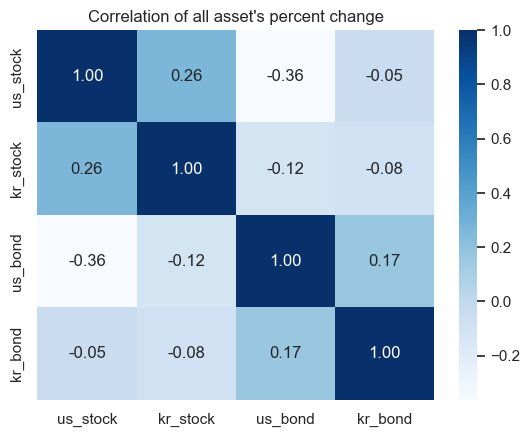

In [31]:
plt.title("Correlation of all asset's percent change")
sns.heatmap(yf_price.pct_change().corr(), cmap='Blues', annot=True, fmt=".2f")
plt.show()

## 변동성(위험) 대비 수익률

* 연 평균 수익률   
    ((마지막날 자산가격 + (배당금) / 첫날 자산 가격 )   * np.sqrt(10)
* 연간 리스크 :     
    분산(변동성 제곱)  = 'W x 공분산 x WT'을 계산  
    표준편차(변동성)   = np.sqrt(분산(변동성 제곱))  

In [32]:
port_ratios = []
port_returns = np.array([])
port_risks = np.array([])
for i in range(10000): # 포트폴리오 비율 조합 10000개
    # 포트폴리오 비율
    port_ratio = np.random.rand(len(yf_price.columns)) # 4가지 랜덤 실수 조합
    port_ratio = port_ratio / port_ratio.sum() # 합계가 1인 랜덤 실수
    port_ratios.append(port_ratio)
    
    # 연 평균 수익률
    total_return_rate = (yf_price.iloc[-1] + yf_dividends.sum()) / yf_price.iloc[0] # 배당금 합산 총 수익률(%)
    annual_avg_rr = total_return_rate ** (1/10) # 연 (기하)평균 수익률(%)
    port_return = np.dot(port_ratio, annual_avg_rr-1) # 연 평균 포트폴리오 수익률 = 연 평균 수익률과 포트폴리오 비율의 행렬곱
    port_returns = np.append(port_returns, port_return)
    
    # 연간 리스크
    annual_cov = yf_price.pct_change().cov() * len(yf_price)/10 # 연간 수익률의 공분산 = 일별 수익률 공분산 * 연간 평균 거래일수
    port_risk = np.sqrt(np.dot(port_ratio.T, np.dot(annual_cov, port_ratio))) # E(Volatility) = sqrt(WT*COV*W)
    port_risks = np.append(port_risks, port_risk)

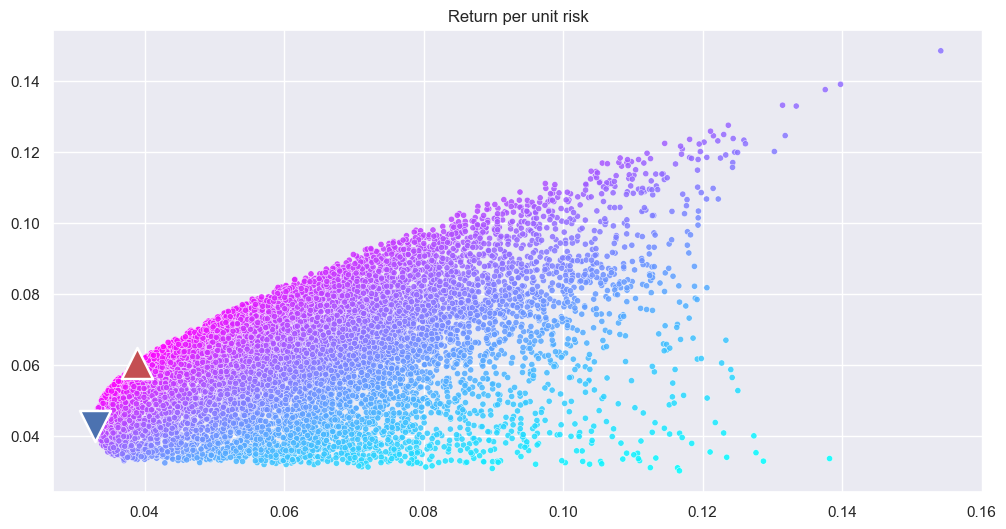

In [33]:
sorted_shape_idx = np.argsort(port_returns/port_risks)
sorted_risk_idx = np.argsort(port_risks)
plt.figure(figsize=(12,6))
sns.scatterplot(x=port_risks, y=port_returns, c=port_returns/port_risks, cmap='cool', alpha=0.85, s=20)
sns.scatterplot(x=port_risks[sorted_shape_idx[-1:]], y=port_returns[sorted_shape_idx[-1:]], color='r', marker='^', s=500)
sns.scatterplot(x=port_risks[sorted_risk_idx[:1]], y=port_returns[sorted_risk_idx[:1]], color='b', marker='v', s=500)

plt.title('Return per unit risk')
plt.show()

In [34]:
port_df = pd.DataFrame(port_ratios)
port_df.head(2)

,0,1,2,3
0,0.114286,0.069985,0.327919,0.48781
1,0.091340,0.208043,0.338347,0.36227


* * https://songseungwon.tistory.com/118

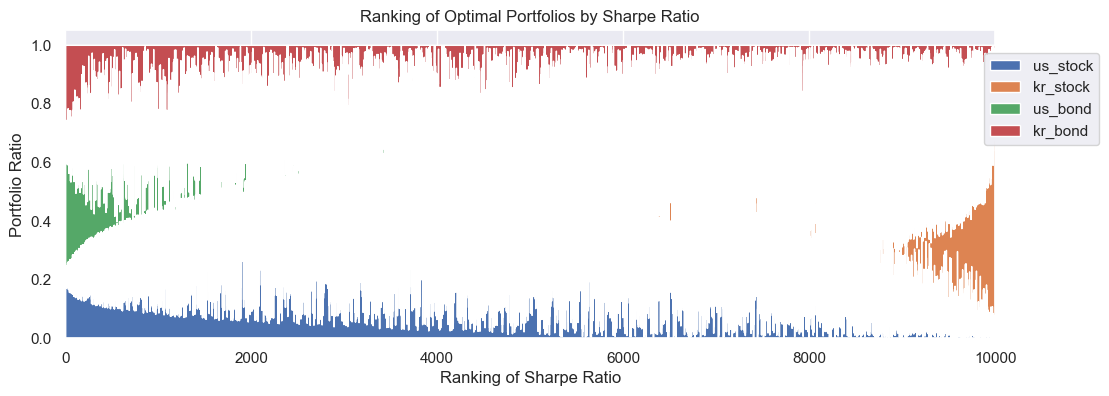

In [35]:
sorted_port_df = port_df.iloc[sorted_shape_idx[::-1]] # 역순
sorted_port_df.columns = yf_price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df)+1,1), np.array(sorted_port_df.T), labels=sorted_port_df.columns)

plt.xlim(0,10000)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()


## 포트폴리오 비율

In [36]:
sorted_returns = port_returns[[sorted_port_df.index]]
sorted_risks = port_risks[[sorted_port_df.index]]


ValueError: 'y1' is not 1-dimensional

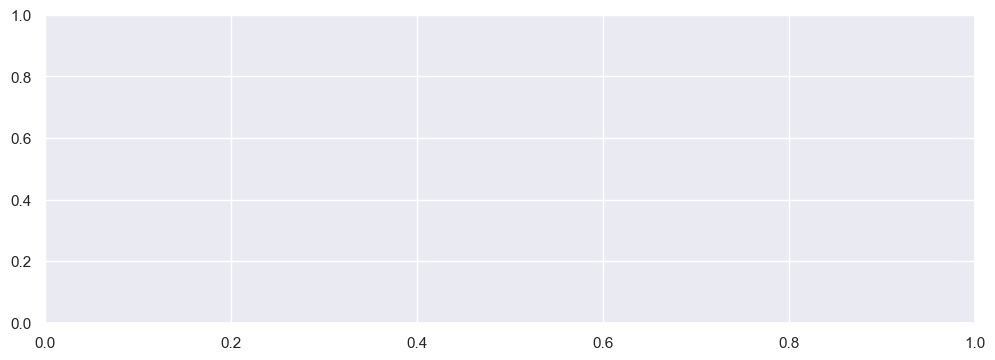

In [37]:

plt.figure(figsize=(12,4))
plt.fill_between(x=np.arange(1,len(sorted_returns)+1,1), y1=sorted_returns.tolist(), label='return')
plt.fill_between(x=np.arange(1,len(sorted_risks)+1,1), y1=sorted_risks.tolist(), alpha=0.3, label='risk')
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Return & Risk')
plt.title('Returns & Risks of Portfolio by Sharpe Ratio Ranking')
plt.legend()
plt.show()


In [ ]:
print(f'최적의 포트폴리오 비율 : \n{pd.Series(sorted_port_df.iloc[0], index=sorted_port_df.columns)}')